In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
slc_or_genes = []
with open("output/SLC-OR_genes.txt") as f:
    for line in f:
        slc_or_genes.append(line.strip())


In [3]:
orf_genesets = [
    slc_or_genes,
    ['YAP1', 'WWTR1', 'VGLL4', 'PRKCE', 'STK3', 'CEP72', 'IL20RB', 'MTMR9'] 
]

channels = ["DNA", "RNA", "Mito", "ER", "AGP"]

overwrite = False

In [4]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol", "Metadata_pert_type"],
)

orf_profiles_with_feature_names_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet"
).merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")

orf_profiles_metadata_df = utils.get_metadata(orf_profiles_with_feature_names_df)

orf_profiles_metadata_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_pert_type
0,source_4,BR00117035,A01,JCP2022_905588,CDK9,trt
1,source_4,BR00117036,A01,JCP2022_905588,CDK9,trt
2,source_4,BR00121558,A01,JCP2022_905588,CDK9,trt
3,source_4,BR00121559,A01,JCP2022_905588,CDK9,trt
4,source_4,BR00121560,A01,JCP2022_905588,CDK9,trt


In [5]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

In [6]:
df = pd.DataFrame()

for geneset in orf_genesets:
    treatment_metadata_df = orf_profiles_metadata_df.query(
        "Metadata_Symbol in @geneset"
    ).sample(n=1, random_state=12527)
    plates_with_genes = list(np.unique(treatment_metadata_df.Metadata_Plate.to_list()))
    negative_control_metadata_df = orf_profiles_metadata_df.query(
        "Metadata_pert_type == 'negcon' and Metadata_Plate in @plates_with_genes"
    ).sample(n=1, random_state=12527)

    orf_df = pd.concat(
        [
            treatment_metadata_df,
            negative_control_metadata_df
        ],
        ignore_index=True,
    )

    if len(geneset) > 20: # hack
        orf_df = orf_df.assign(cluster='-'.join(geneset[:5]), modality="ORF")
    else:
        orf_df = orf_df.assign(cluster='-'.join(geneset), modality="ORF")

    orf_df = orf_df.merge(plate_df, on="Metadata_Plate", how="left")

    df = pd.concat(
        [
            df,
            orf_df
        ],
        ignore_index=True
    )

In [7]:
df = df.drop_duplicates(subset=["Metadata_JCP2022"])

temp_df = pd.DataFrame()

for channel in channels:
    temp_df = pd.concat(
        [
            temp_df,
            df.assign(channel=channel)
        ],
        ignore_index=True,
    )

df = temp_df.copy()

In [8]:
if overwrite:
    os.system("rm -rf cluster_images_yap1_slc_or")
    os.system("mkdir cluster_images_yap1_slc_or")

    for jcpid in df.Metadata_JCP2022.unique():
        os.system(f"mkdir cluster_images_yap1_slc_or/{jcpid}")
    utils.download_images(df, folder="cluster_images_yap1_slc_or")

Create Montage

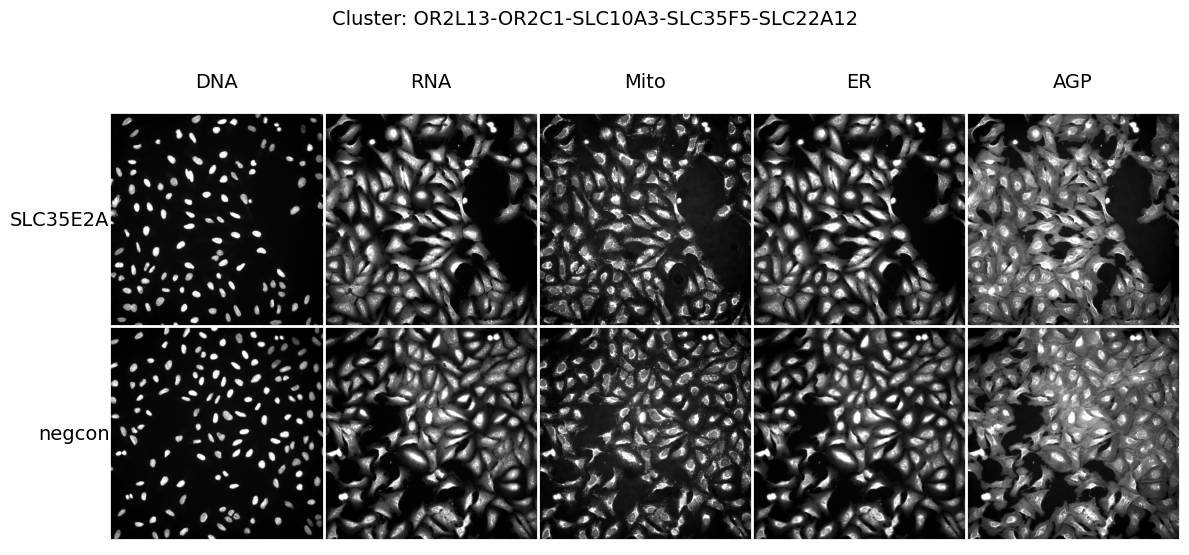

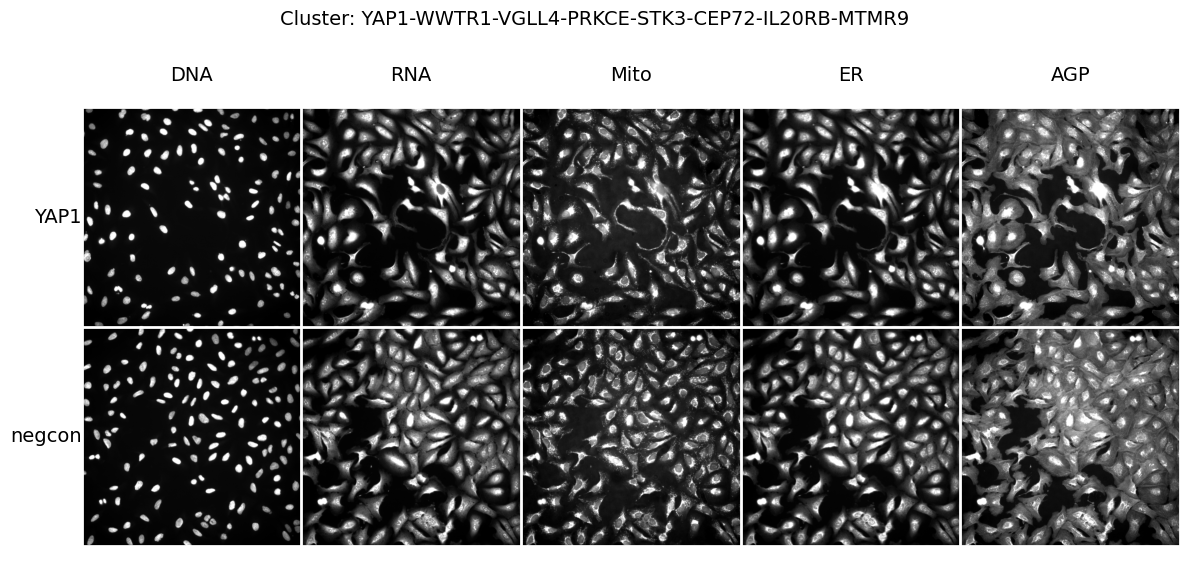

In [9]:
col_labels = channels

for gene in df.query("Metadata_pert_type == 'trt'").Metadata_Symbol.unique():
    images = []
    temp_df = df.query("Metadata_Symbol == @gene").drop_duplicates(
        subset=["Metadata_JCP2022"]
    )
    cluster = temp_df.cluster.values[0]
    jcpid = temp_df.Metadata_JCP2022.to_list()
    modality = temp_df.modality.values[0]
    negcons = df.query(
        "Metadata_pert_type == 'negcon' & modality == @modality"
    ).drop_duplicates(subset=["Metadata_JCP2022"]).Metadata_JCP2022.to_list()

    row_labels = [gene] + ["negcon" for i in range(len(negcons))]

    for perturbation in jcpid+negcons:
        for channel in channels:
            filename = f"cluster_images_yap1_slc_or/{perturbation}/{perturbation}_{channel}.tiff"
            img = skimage.io.imread(filename)
            img = utils.standardize_image(img, target_size=(1080, 1080))
            img = utils.brighten_contrast_stretch(img, 2, 98)
            images.append(img)
    
    grid_shape = (len(jcpid)+len(negcons), len(channels))

    fig = utils.create_facet_grid_montage(
        images, row_labels, col_labels, grid_shape, title=f"Cluster: {cluster}"
    )

    # Display the figure
    plt.show()

    # Save the figure    
    fig.savefig(f"figures/facet_grid_montage_orf_{cluster}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"figures/facet_grid_montage_orf_{cluster}.svg", dpi=300, bbox_inches="tight")